In [31]:
print('start')
import os
import json
import cv2
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from os import mkdir,path
from shutil import rmtree
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

start


## prepare folders

In [32]:
# image_index=1
image_index='b'
big_height=120
small_height=70

In [33]:
if path.isdir('test'):
    rmtree('test')
if path.isdir('results'):
    rmtree('results')

In [34]:
mkdir('test')
mkdir('results')

In [35]:
# small_image=Image.open('data/{}_small.png'.format(image_index)).convert('RGB')
# small_image.save('test/small.png')

# big_image=Image.open('data/{}_big.png'.format(image_index)).convert('RGB')
# big_image_cv2_plis=cv2.imread('data/{}_big.png'.format(image_index))


small_image=Image.open('data/dron/{}-{}.JPG'.format(image_index,small_height)).convert('RGB')
small_image=small_image.resize((1920,1080))
small_image=small_image.crop((420,0,1500,1080))
small_image=small_image.resize((int(1080 * small_height/big_height),int(1080* small_height/big_height)))


small_image.save('test/small.png')
small_image.save('results/a.png')

big_image=Image.open('data/dron/{}-{}.JPG'.format(image_index,big_height)).convert('RGB')
big_image=big_image.resize((1920,1080))
big_image=big_image.crop((420,0,1500,1080))

big_image.save('results/b.png')

big_image_cv2_plis=cv2.imread('data/dron/{}-{}.JPG'.format(image_index,big_height))
big_image_cv2_plis=cv2.resize(big_image_cv2_plis,(1920,1080))
big_image_cv2_plis = big_image_cv2_plis[0:1080,420:1500]

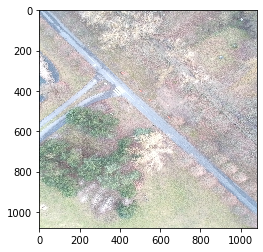

In [36]:
plt.imshow(big_image)

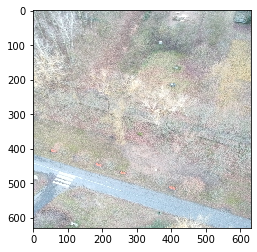

In [37]:
plt.imshow(small_image)

## prepare einvironemnt

## transforms

In [38]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

w,h=small_image.size
print(w,h)
data_transforms_small = transforms.Compose([
    transforms.CenterCrop(w),
    # below are for tests
#     transforms.ColorJitter(brightness=1,contrast=1,saturation=1),
    transforms.ToTensor(),
    normalize
])

data_transforms_big = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

630 630


In [39]:
big_image_transform=data_transforms_big(big_image)
plt.imsave('test/big.png',big_image_transform.numpy()[2])

big_image_transform=big_image_transform.numpy().transpose(1, 2, 0)
big_image_transform=big_image_transform.astype(np.float32)
plt.imsave('test/big2.png',big_image_transform[0])


In [40]:
small_images_torch=[]

In [41]:
for rotate_angle in range(0,360,10):
    rotation_45_procent = (rotate_angle%45)/45
    scale=(rotation_45_procent * 0.51)+1
    w,h=small_image.size
    w_scale=int(w*scale)
    h_scale=int(h*scale)
    print(rotate_angle,scale,w_scale,h_scale)
    
    
    small_image_transform=small_image.resize((w_scale,h_scale)).rotate(rotate_angle)
#     small_image_transform=small_image_transform.resize((w,h))
#     small_image_transform=small_image.rotate(rotate_angle)
    small_image_transform.save('test/zzz{}.png'.format(rotate_angle))
    
    small_image_torch = data_transforms_small(small_image_transform)
    
    if rotate_angle%20==0:
        plt.imsave('test/test-{}.png'.format(rotate_angle),small_image_torch.numpy()[0])
        
    
    small_images_torch.append(small_image_torch.unsqueeze(0))

0 1.0 630 630
10 1.1133333333333333 701 701
20 1.2266666666666666 772 772
30 1.3399999999999999 844 844
40 1.4533333333333334 915 915
50 1.0566666666666666 665 665
60 1.17 737 737
70 1.2833333333333332 808 808
80 1.3966666666666667 879 879
90 1.0 630 630
100 1.1133333333333333 701 701
110 1.2266666666666666 772 772
120 1.3399999999999999 844 844
130 1.4533333333333334 915 915
140 1.0566666666666666 665 665
150 1.17 737 737
160 1.2833333333333332 808 808
170 1.3966666666666667 879 879
180 1.0 630 630
190 1.1133333333333333 701 701
200 1.2266666666666666 772 772
210 1.3399999999999999 844 844
220 1.4533333333333334 915 915
230 1.0566666666666666 665 665
240 1.17 737 737
250 1.2833333333333332 808 808
260 1.3966666666666667 879 879
270 1.0 630 630
280 1.1133333333333333 701 701
290 1.2266666666666666 772 772
300 1.3399999999999999 844 844
310 1.4533333333333334 915 915
320 1.0566666666666666 665 665
330 1.17 737 737
340 1.2833333333333332 808 808
350 1.3966666666666667 879 879


In [42]:
print(small_images_torch[10].size())
len(small_images_torch)

torch.Size([1, 3, 630, 630])


36

## cv2 template

In [43]:
max_m=-100
max_loc=None

for torch_image in small_images_torch:
    template_image=torch_image[0].numpy().transpose(1, 2, 0)
    template_image=template_image.astype(np.float32)
    
    w, h = template_image.shape[:-1]
    
    result = cv2.matchTemplate(big_image_transform, template_image, cv2.TM_CCOEFF_NORMED)
  
    if np.amax(result)>max_m:
        max_m=np.amax(result)
        print(max_m,max_loc)
    loc = np.where(result >= max_m)

    for pt in zip(*loc[::-1]): 
        max_loc=pt
        print(max_m,max_loc)
        

print(max_m,max_loc)
cv2.rectangle(big_image_cv2_plis, max_loc, (max_loc[0]+ h, max_loc[1]+ w),(0, 0, 255), 1)

0.17251204 None
0.17251204 (359, 0)
0.30196953 (359, 0)
0.30196953 (252, 17)
0.31228396 (252, 17)
0.31228396 (234, 33)
0.3191451 (234, 33)
0.3191451 (252, 21)
0.32152373 (252, 21)
0.32152373 (267, 8)
0.32152373 (267, 8)


array([[[188, 164, 142],
        [190, 166, 144],
        [203, 179, 157],
        ...,
        [181, 179, 171],
        [181, 179, 171],
        [171, 169, 161]],

       [[187, 162, 142],
        [190, 165, 144],
        [189, 164, 143],
        ...,
        [162, 159, 151],
        [174, 172, 163],
        [178, 175, 167]],

       [[183, 157, 140],
        [184, 159, 139],
        [194, 169, 149],
        ...,
        [177, 174, 167],
        [175, 172, 164],
        [177, 174, 166]],

       ...,

       [[196, 230, 219],
        [198, 232, 221],
        [199, 232, 218],
        ...,
        [197, 190, 197],
        [188, 181, 188],
        [188, 181, 188]],

       [[193, 227, 216],
        [198, 232, 221],
        [206, 238, 227],
        ...,
        [195, 189, 196],
        [193, 186, 193],
        [193, 186, 192]],

       [[199, 233, 222],
        [199, 233, 222],
        [204, 236, 225],
        ...,
        [186, 182, 188],
        [181, 174, 181],
        [187, 181, 185]]

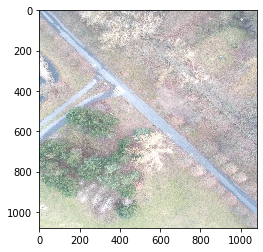

In [44]:
cv2.imwrite('results/finall_image.png', big_image_cv2_plis)
plt.imshow(big_image_cv2_plis[:,:,::-1])

In [45]:
print('end')

end
